# DLS-HW5
### Part 4

In [1]:
import numpy as np
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.util import view_as_blocks
import matplotlib.pyplot as plt
import tensorflow as tf
%tensorflow_version 2.x
# print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, GRU, Dense, Flatten, Dropout, Input, InputLayer, LeakyReLU, GlobalMaxPooling2D, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import HeNormal, HeUniform
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy

In [2]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

x_train, y_train = x_train/255, y_train/255

In [4]:
X = x_train
X_og = X
X = X[:, 10:20, 10:20]
X.shape

(60000, 10, 10)

In [5]:
x_test_center = x_test[:, 10:20, 10:20]

In [6]:
LATENT_DIM=100
IMAGE_DIM=28
CONDITIONAL_DIM = 100
GEN_IN_SHAPE = LATENT_DIM+CONDITIONAL_DIM
DIS_IN_SHAPE = (IMAGE_DIM,IMAGE_DIM, 1)
EPOCHS = 20
LAMBDA = 10 # lambda for mse
BATCH_SIZE = 100

In [7]:
# def discriminator(in_shape):
model_discriminator = Sequential([
                      InputLayer(DIS_IN_SHAPE, name='Input_layer'),
                      Conv2D(64, 4, strides=2, padding="same", name='C2D_1'),
                      LeakyReLU(alpha=0.2, name='LRelu_1'),
                      Conv2D(64, 4, strides=2, padding="same", name='C2D_2'),
                      LeakyReLU(alpha=0.2, name='LRelu_2'),
                      Dropout(0.2, name='drop0.2'),
                      Flatten(),
                      Dense(1, activation='sigmoid', name='out')

                      # Conv2D(64, 4, strides=2, padding="same"),

  ], name='discriminator')
model_discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C2D_1 (Conv2D)              (None, 14, 14, 64)        1088      
                                                                 
 LRelu_1 (LeakyReLU)         (None, 14, 14, 64)        0         
                                                                 
 C2D_2 (Conv2D)              (None, 7, 7, 64)          65600     
                                                                 
 LRelu_2 (LeakyReLU)         (None, 7, 7, 64)          0         
                                                                 
 drop0.2 (Dropout)           (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 out (Dense)                 (None, 1)               

In [8]:
# def discriminator(in_shape):
model_generator = Sequential([
                      InputLayer((GEN_IN_SHAPE,), name='Input_layer'),
                      Dense(8*8*GEN_IN_SHAPE),
                      Reshape((8,8,GEN_IN_SHAPE)),
                      Conv2DTranspose(64, 4, strides=2, padding="same", name='CT2D_1'),
                      LeakyReLU(alpha=0.2, name='LRelu_1'),
                      Conv2DTranspose(64, 4, strides=2, padding="same", name='CT2D_2'),
                      LeakyReLU(alpha=0.2, name='LRelu_2'),
                      Dropout(0.2, name='drop0.2'),
                      Conv2D(1,5, activation='sigmoid', name='out')

                      # Conv2D(64, 4, strides=2, padding="same"),

  ], name='generator')
model_generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12800)             2572800   
                                                                 
 reshape (Reshape)           (None, 8, 8, 200)         0         
                                                                 
 CT2D_1 (Conv2DTranspose)    (None, 16, 16, 64)        204864    
                                                                 
 LRelu_1 (LeakyReLU)         (None, 16, 16, 64)        0         
                                                                 
 CT2D_2 (Conv2DTranspose)    (None, 32, 32, 64)        65600     
                                                                 
 LRelu_2 (LeakyReLU)         (None, 32, 32, 64)        0         
                                                                 
 drop0.2 (Dropout)           (None, 32, 32, 64)        0 

In [9]:
# optimizers and loss fn

opt_gen, opt_dis, loss_fn = Adam(learning_rate=0.0002), Adam(learning_rate=0.0002), BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()


In [10]:

dataset = X_og.reshape((-1, BATCH_SIZE, 28, 28))
dataset.shape

(600, 100, 28, 28)

In [11]:
for epoch in range(EPOCHS):
  print(f'Epoch:{epoch}')
  for index, real in enumerate(tqdm(dataset)):
    batch_size = real.shape[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, LATENT_DIM))
    condition = real[:, 10:20, 10:20].reshape(-1, 100)
    # print(condition.shape)

    random_latent_vectors_with_condition = tf.concat([random_latent_vectors, condition], axis=1)

    fake = model_generator(random_latent_vectors_with_condition)
    # print(fake.shape)
    # train the discriminator
    with tf.GradientTape() as dis_tape:
      # fake = model_generator(random_latent_vectors_with_condition)
      loss_dis_real = loss_fn(tf.ones((batch_size, 1)), model_discriminator(real))
      loss_dis_fake = loss_fn(tf.zeros((batch_size, 1)), model_discriminator(fake))
      
      loss_dic = loss_dis_real + loss_dis_fake
      

    grads = dis_tape.gradient(loss_dic, model_discriminator.trainable_weights)
    opt_dis.apply_gradients(zip(grads, model_discriminator.trainable_weights))


    #train the generator
    with tf.GradientTape() as gen_tape:
      fake = model_generator(random_latent_vectors_with_condition)
      generated = model_discriminator(fake)
      # print((tf.convert_to_tensor(condition, dtype=tf.float32).dtype))
      loss_gen_generated = loss_fn(np.ones((batch_size, 1)), generated)
      # cal mse loss 
      loss_center_pixels = mse(tf.reshape(fake[:, 10:20, 10:20], (-1,100)), tf.convert_to_tensor(condition, dtype=tf.float32))
      # print(loss_center_pixels)
      loss_gen = loss_gen_generated + LAMBDA * loss_center_pixels
      


    grads = gen_tape.gradient(loss_gen, model_generator.trainable_weights)
    opt_gen.apply_gradients(
        zip(grads, model_generator.trainable_weights)
    )
  print(f'dis_loss: {loss_dic}')
  print(f'gen_loss: {loss_gen}')
  print('='*10)
    





Epoch:0


100%|██████████| 600/600 [00:27<00:00, 22.20it/s]


dis_loss: 0.7014985680580139
gen_loss: 1.973913311958313
Epoch:1


100%|██████████| 600/600 [00:25<00:00, 23.25it/s]


dis_loss: 1.1450369358062744
gen_loss: 1.5164650678634644
Epoch:2


100%|██████████| 600/600 [00:25<00:00, 23.32it/s]


dis_loss: 2.9466745853424072
gen_loss: 2.1322877407073975
Epoch:3


100%|██████████| 600/600 [00:25<00:00, 23.32it/s]


dis_loss: 1.6557488441467285
gen_loss: 1.0478687286376953
Epoch:4


100%|██████████| 600/600 [00:25<00:00, 23.30it/s]


dis_loss: 0.7156071066856384
gen_loss: 2.6845576763153076
Epoch:5


100%|██████████| 600/600 [00:25<00:00, 23.29it/s]


dis_loss: 1.0990750789642334
gen_loss: 1.0001120567321777
Epoch:6


100%|██████████| 600/600 [00:25<00:00, 23.23it/s]


dis_loss: 0.5551146864891052
gen_loss: 1.8726613521575928
Epoch:7


100%|██████████| 600/600 [00:25<00:00, 23.20it/s]


dis_loss: 1.160881757736206
gen_loss: 0.9727637767791748
Epoch:8


100%|██████████| 600/600 [00:25<00:00, 23.27it/s]


dis_loss: 1.4828150272369385
gen_loss: 1.052585482597351
Epoch:9


100%|██████████| 600/600 [00:26<00:00, 23.08it/s]


dis_loss: 1.2972345352172852
gen_loss: 0.9804592132568359
Epoch:10


100%|██████████| 600/600 [00:25<00:00, 23.22it/s]


dis_loss: 1.2792422771453857
gen_loss: 1.0269063711166382
Epoch:11


100%|██████████| 600/600 [00:26<00:00, 23.05it/s]


dis_loss: 1.225287914276123
gen_loss: 1.1955684423446655
Epoch:12


100%|██████████| 600/600 [00:25<00:00, 23.13it/s]


dis_loss: 1.1624377965927124
gen_loss: 0.9144660234451294
Epoch:13


100%|██████████| 600/600 [00:25<00:00, 23.25it/s]


dis_loss: 1.4278600215911865
gen_loss: 0.8806008100509644
Epoch:14


100%|██████████| 600/600 [00:25<00:00, 23.23it/s]


dis_loss: 0.9972800016403198
gen_loss: 1.0368421077728271
Epoch:15


100%|██████████| 600/600 [00:25<00:00, 23.21it/s]


dis_loss: 1.3788903951644897
gen_loss: 0.952051043510437
Epoch:16


100%|██████████| 600/600 [00:25<00:00, 23.43it/s]


dis_loss: 1.5125982761383057
gen_loss: 0.9156699180603027
Epoch:17


100%|██████████| 600/600 [00:25<00:00, 23.53it/s]


dis_loss: 1.6461952924728394
gen_loss: 0.6721206307411194
Epoch:18


100%|██████████| 600/600 [00:25<00:00, 23.29it/s]


dis_loss: 1.396640419960022
gen_loss: 1.0210329294204712
Epoch:19


100%|██████████| 600/600 [00:25<00:00, 23.34it/s]

dis_loss: 1.7670406103134155
gen_loss: 0.7473465204238892


In [12]:
x_test_center.shape

(10000, 10, 10)

In [13]:
latent = np.random.uniform(size=(x_test_center.shape[0], LATENT_DIM))
X_latent_with_condition = np.concatenate([latent, x_test_center.reshape((-1, 100))], axis=1)
X_latent_with_condition.shape

(10000, 200)

In [14]:
# tf.concat([x[:,:5], np.ones((3, 5))], axis=1)

NameError: ignored

In [15]:
fakes = model_generator.predict(X_latent_with_condition)
fakes.shape

(10000, 28, 28, 1)

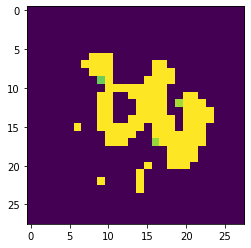

In [16]:
plt.imshow(fakes[7].reshape(28, 28)*255)
plt.show()

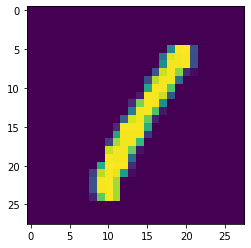

In [17]:
plt.imshow(X_og[3].reshape(28, 28)*255)
plt.show()